In [4]:
import pandas as pd

df = pd.read_parquet("../data/processed/feature_engineered.parquet")

target = "fail_in_7_days"

drop_cols = [
    target,
    "failure",
    "date",
    "serial_number",
    "model",
    "capacity_bytes",
    "fail_date"
]

X = df.drop(columns=drop_cols)
y = df[target]

for col in ["smart_187_raw", "smart_188_raw"]:
    X[col + "_missing"] = X[col].isna().astype(int)
X = X.fillna(0)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [10]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

threshold = 0.05
y_pred = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9696284874545743
[[582487  62157]
 [     4     71]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    644644
           1       0.00      0.95      0.00        75

    accuracy                           0.90    644719
   macro avg       0.50      0.93      0.48    644719
weighted avg       1.00      0.90      0.95    644719



In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix

thresholds = np.linspace(0.01, 0.5, 20)

print("thresh | recall | precision | predicted_1 | TP | FP")
print("-"*65)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    
    cm = confusion_matrix(y_test, y_pred_t)
    tn, fp, fn, tp = cm.ravel()
    
    predicted_1 = tp + fp
    
    print(f"{t:.2f} | {recall:.3f} | {precision:.4f} | {predicted_1:10d} | {tp:3d} | {fp:6d}")


thresh | recall | precision | predicted_1 | TP | FP
-----------------------------------------------------------------
0.01 | 0.960 | 0.0007 |     107722 |  72 | 107650
0.04 | 0.947 | 0.0011 |      66006 |  71 |  65935
0.06 | 0.947 | 0.0012 |      61723 |  71 |  61652
0.09 | 0.933 | 0.0012 |      58691 |  70 |  58621
0.11 | 0.920 | 0.0012 |      58328 |  69 |  58259
0.14 | 0.920 | 0.0012 |      58146 |  69 |  58077
0.16 | 0.920 | 0.0012 |      58019 |  69 |  57950
0.19 | 0.920 | 0.0012 |      57847 |  69 |  57778
0.22 | 0.920 | 0.0012 |      57802 |  69 |  57733
0.24 | 0.920 | 0.0012 |      57756 |  69 |  57687
0.27 | 0.920 | 0.0012 |      57713 |  69 |  57644
0.29 | 0.920 | 0.0012 |      57682 |  69 |  57613
0.32 | 0.920 | 0.0012 |      57588 |  69 |  57519
0.35 | 0.920 | 0.0012 |      57571 |  69 |  57502
0.37 | 0.920 | 0.0012 |      57541 |  69 |  57472
0.40 | 0.920 | 0.0012 |      57516 |  69 |  57447
0.42 | 0.920 | 0.0012 |      57492 |  69 |  57423
0.45 | 0.920 | 0.0012 |      574

In [14]:
from sklearn.metrics import average_precision_score
print("PR-AUC:", average_precision_score(y_test, y_proba))

PR-AUC: 0.4266162284429843


In [17]:
k = int(len(y_proba) * 0.005)

indices = y_proba.argsort()[::-1][:k]

y_pred_topk = np.zeros_like(y_proba)
y_pred_topk[indices] = 1

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_topk))
print(classification_report(y_test, y_pred_topk))


[[641470   3174]
 [    26     49]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644644
           1       0.02      0.65      0.03        75

    accuracy                           1.00    644719
   macro avg       0.51      0.82      0.51    644719
weighted avg       1.00      1.00      1.00    644719



In [18]:
for pct in [0.005, 0.01, 0.02, 0.05]:
    k = int(len(y_proba) * pct)
    indices = y_proba.argsort()[::-1][:k]
    y_pred_topk = np.zeros_like(y_proba)
    y_pred_topk[indices] = 1
    
    print(f"\nTop {pct*100:.1f}%")
    print(classification_report(y_test, y_pred_topk))



Top 0.5%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    644644
           1       0.02      0.65      0.03        75

    accuracy                           1.00    644719
   macro avg       0.51      0.82      0.51    644719
weighted avg       1.00      1.00      1.00    644719


Top 1.0%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    644644
           1       0.01      0.68      0.02        75

    accuracy                           0.99    644719
   macro avg       0.50      0.84      0.51    644719
weighted avg       1.00      0.99      0.99    644719


Top 2.0%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    644644
           1       0.00      0.71      0.01        75

    accuracy                           0.98    644719
   macro avg       0.50      0.84      0.50    644719
weighted avg       1.00      0.98      0.99 

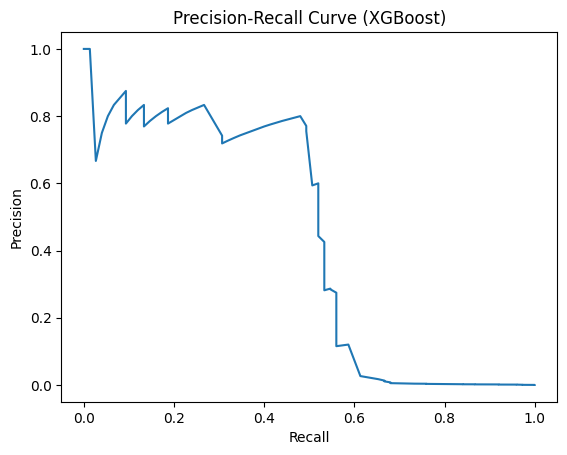

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()


In [21]:
from sklearn.model_selection import RandomizedSearchCV

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=15,
    scoring="average_precision",  # PR-AUC
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best PR-AUC:", random_search.best_score_)
print("Best params:", random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best PR-AUC: 0.31901057589895854
Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [22]:
best_xgb = random_search.best_estimator_

y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import average_precision_score

print("Test PR-AUC:", average_precision_score(y_test, y_proba_best))


Test PR-AUC: 0.48564294128162205


In [24]:
thresholds = np.linspace(0.01, 0.5, 20)

for t in thresholds:
    y_pred_t = (y_proba_best >= t).astype(int)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t)
    
    print(f"Threshold {t:.2f} | Recall {recall:.3f} | Precision {precision:.4f}")


Threshold 0.01 | Recall 0.947 | Precision 0.0010
Threshold 0.04 | Recall 0.947 | Precision 0.0012
Threshold 0.06 | Recall 0.947 | Precision 0.0012
Threshold 0.09 | Recall 0.920 | Precision 0.0012
Threshold 0.11 | Recall 0.920 | Precision 0.0012
Threshold 0.14 | Recall 0.907 | Precision 0.0012
Threshold 0.16 | Recall 0.907 | Precision 0.0012
Threshold 0.19 | Recall 0.907 | Precision 0.0012
Threshold 0.22 | Recall 0.907 | Precision 0.0012
Threshold 0.24 | Recall 0.907 | Precision 0.0012
Threshold 0.27 | Recall 0.907 | Precision 0.0012
Threshold 0.29 | Recall 0.907 | Precision 0.0012
Threshold 0.32 | Recall 0.907 | Precision 0.0012
Threshold 0.35 | Recall 0.907 | Precision 0.0012
Threshold 0.37 | Recall 0.907 | Precision 0.0012
Threshold 0.40 | Recall 0.907 | Precision 0.0012
Threshold 0.42 | Recall 0.907 | Precision 0.0012
Threshold 0.45 | Recall 0.907 | Precision 0.0012
Threshold 0.47 | Recall 0.907 | Precision 0.0012
Threshold 0.50 | Recall 0.907 | Precision 0.0015
